## Some plots created with values that were produces by U-net and CE-net models

### Matty Vermet


### SUBQUESTION 1

In [ ]:
import os
import sys
import random
import warnings
import re

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
from scipy import stats
import statistics
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

In [ ]:
BATCH_SIZE = 30 # the higher the better
IMG_WIDTH = 224 # for faster computing on kaggle
IMG_HEIGHT = 224 # for faster computing on kaggle
IMG_CHANNELS = 3
TRAIN_PATH_IMG_1 = '../input/nuclei-detection-for-segmentation/Fold__1/Fold_1/content/Fold 1/images'
TRAIN_PATH_MASK_1 = '../input/nuclei-detection-for-segmentation/Fold__1/Fold_1/content/Fold 1/masks'
VAL_PATH_IMG_2 = '../input/nuclei-detection-for-segmentation/Fold__2/Fold_2/content/Fold 2/images'
VAL_PATH_MASK_2 = '../input/nuclei-detection-for-segmentation/Fold__2/Fold_2/content/Fold 2/masks'
TEST_PATH_IMG_3 = '../input/nuclei-detection-for-segmentation/Fold__3/Fold_3/content/Fold 3/images'
TEST_PATH_MASK_3 = '../input/nuclei-detection-for-segmentation/Fold__3/Fold_3/content/Fold 3/masks'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

# get
ids_1 = next(os.walk(TRAIN_PATH_IMG_1))[2]
ids_2 = next(os.walk(VAL_PATH_IMG_2))[2]
ids_3 = next(os.walk(TEST_PATH_IMG_3))[2]


In [ ]:
# Load train images and corresponding masks from Fold 1
removal = []

# Create empty arrays to store images and masks
X_train = np.zeros((len(ids_1) - len(removal), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# Y_train = np.zeros((len(ids_1) - len(removal), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
Y_train_panoptic = np.zeros((len(ids_1) - len(removal), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

types_train = []
ratio_pos_pixels = []

# Set counters and list for saving IDs of images
count = 0
index = 0
ids_train = []

print('Load train images and masks from FOLD 1 and resize')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(ids_1), total=len(ids_1)):
    ids_train.append(id_)
    path = TRAIN_PATH_IMG_1 + '/' + id_
    
    if path not in removal:  # Check if image is not an outlier
        # get numbers from id_
        number = re.findall(r'\d+', id_) 
        res = list(map(int, number))
                
        # Load type        
        type_ = np.load( f'../input/nuclei-detection-for-segmentation/Fold__1/Fold_1/content/Fold 1/types/type_{res[0]}.npy')
        type_ = type_.tolist()
        types_train.append(type_)       

        # Load image
        img = np.load(path)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[index] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
                
        # Load mask
        path = TRAIN_PATH_MASK_1 + '/mask_' + str(res[0]) + ".npy"
        mask_ = np.load(path, allow_pickle=True)
        positive_pixel_count = mask_[:,:,5].sum() # assumes binary mask
        ratio_pos_pixels.append(positive_pixel_count / (256*256))
        if positive_pixel_count == 0:
            mask_panoptic = mask_[:,:,0] + mask_[:,:,1] + mask_[:,:,2] + mask_[:,:,3] + mask_[:,:,4]
            mask_panoptic = np.expand_dims(cv2.resize(mask_panoptic, dsize=(IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_NEAREST), axis=-1)
      
            Y_train_panoptic[index] = mask_panoptic
        
        else:       
            
            mask_panoptic = mask_[:,:,0] + mask_[:,:,1] + mask_[:,:,2] + mask_[:,:,3] + mask_[:,:,4]
            mask_panoptic = np.expand_dims(cv2.resize(mask_panoptic, dsize=(IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_NEAREST), axis=-1)
            
            Y_train_panoptic[index] = mask_panoptic

        index += 1
    else:
        count += 1
        
print("Finished part 1 TRAIN SET")
print("noise and outliers: ", count)
print("Index: ", index)

In [ ]:
# Load validation images and corresponding masks from Fold 2

removal = []

# Create empty arays to store images and masks
X_val = np.zeros((len(ids_2) - len(removal), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# Y_val = np.zeros((len(ids_2) - len(removal), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
Y_val_panoptic = np.zeros((len(ids_2) - len(removal), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

types_val = []

# Set counters and list for saving IDs of images
count = 0
index = 0
ids_val = []

print('Load validation images and masks from FOLD 2 and resize')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(ids_2), total=len(ids_2)):
    ids_val.append(id_)
    path = VAL_PATH_IMG_2 + '/' + id_
    
    if path not in removal:   # Check if image is not an outlier
        # get numbers from id_
        number = re.findall(r'\d+', id_) 
        res = list(map(int, number))
        
        # Load type        
        type_ = np.load( f'../input/nuclei-detection-for-segmentation/Fold__2/Fold_2/content/Fold 2/types/type_{res[0]}.npy')
        type_ = type_.tolist()
        types_val.append(type_) 
        
        # load image
        img = np.load(path)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_val[index] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        
        # load mask
        path = VAL_PATH_MASK_2 + '/mask_' + str(res[0]) + ".npy"
        mask_ = np.load(path, allow_pickle=True)
        mask_panoptic = mask_[:,:,0] + mask_[:,:,1] + mask_[:,:,2] + mask_[:,:,3] + mask_[:,:,4]

        positive_pixel_count = mask_[:,:,5].sum() # assumes binary mask
        ratio_pos_pixels.append(positive_pixel_count / (256*256))

        if positive_pixel_count == 0:
            mask_panoptic = mask_[:,:,0] + mask_[:,:,1] + mask_[:,:,2] + mask_[:,:,3] + mask_[:,:,4]
            mask_panoptic = np.expand_dims(resize(mask_panoptic, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                          preserve_range=True), axis=-1)
    
            Y_val_panoptic[index] = mask_panoptic
        
        else:       
            mask_panoptic = mask_[:,:,0] + mask_[:,:,1] + mask_[:,:,2] + mask_[:,:,3] + mask_[:,:,4]
            mask_panoptic = np.expand_dims(resize(mask_panoptic, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                          preserve_range=True), axis=-1)
 
            Y_val_panoptic[index] = mask_panoptic
        
        index += 1


    else:
        count += 1
        
print("Finished part 2 VAL SET")
print("Index: ", index)
print("noise and outliers: ", count)

In [ ]:
removal = []

#Create empty arrays to store images and masks
X_test = np.zeros((len(ids_3) - len(removal), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# Y_test = np.zeros((len(ids_3) - len(removal), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
Y_test_panoptic = np.zeros((len(ids_3) - len(removal), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

types_test = []

# Set counters and list for saving IDs of images
count_test = 0
index = 0
ids_test = []

print('Load test images and masks from FOLD 3 and resize')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(ids_3), total=len(ids_3)):
    
    path = TEST_PATH_IMG_3 + '/' + id_
    
    if path not in removal:  # Check if image is not an outlier
        ids_test.append(id_)
        # get numbers from id_
        number = re.findall(r'\d+', id_) 
        res = list(map(int, number))
        
        # Load type        
        type_ = np.load( f'../input/nuclei-detection-for-segmentation/Fold__3/Fold_3/content/Fold 3/types/type_{res[0]}.npy')
        type_ = type_.tolist()
        types_test.append(type_)       

        # Load image
        img = np.load(path)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[index] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
                
        # Load mask
        path = TEST_PATH_MASK_3 + '/mask_' + str(res[0]) + ".npy"
        mask_ = np.load(path, allow_pickle=True)
        
        positive_pixel_count = mask_[:,:,5].sum() # assumes binary mask
        ratio_pos_pixels.append(positive_pixel_count / (256*256))

        if positive_pixel_count == 0:
            mask_panoptic = mask_[:,:,0] + mask_[:,:,1] + mask_[:,:,2] + mask_[:,:,3] + mask_[:,:,4]
            mask_panoptic = np.expand_dims(cv2.resize(mask_panoptic, dsize=(IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_NEAREST), axis=-1)

            Y_test_panoptic[index] = mask_panoptic
        
        else:       
            mask_panoptic = mask_[:,:,0] + mask_[:,:,1] + mask_[:,:,2] + mask_[:,:,3] + mask_[:,:,4]
            mask_panoptic = np.expand_dims(cv2.resize(mask_panoptic, dsize=(IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_NEAREST), axis=-1)

            Y_test_panoptic[index] = mask_panoptic

        index += 1
    else:
        count_test += 1
        
print("Finished TEST SET")
print("Noise and outliers: ", count_test)
print("Index: ", index)


In [ ]:
area_nuclei_train = []
len_contour_list_train = []
for i in range(0, len(Y_train_panoptic)):

    mask = (Y_train_panoptic[i]*2).astype('uint8')    
    img  = X_train[i]

    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    len_contour_list_train.append(len(cnts))

    # count nuclei area for every image in train set
    for c in cnts:
        area = cv2.contourArea(c)
        area_nuclei_train.append(area)

area_nuclei_val = []
len_contour_list_val = []
for i in range(0, len(Y_val_panoptic)):

    mask = (Y_val_panoptic[i]*2).astype('uint8')    
    img  = X_val[i]

    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    len_contour_list_val.append(len(cnts))

    # count nuclei area for every image in validation set
    for c in cnts:
        area = cv2.contourArea(c)
        area_nuclei_val.append(area)
        
area_nuclei_test = []
len_contour_list_test = []
for i in range(0, len(Y_test_panoptic)):

    mask = (Y_test_panoptic[i]*2).astype('uint8')    
    img  = X_test[i]

    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    len_contour_list_test.append(len(cnts))

    # count nuclei area for every image in test set
    for c in cnts:
        area = cv2.contourArea(c)
        area_nuclei_test.append(area)


### Plot distribution of number of nuclei and their sizes

In [ ]:
import seaborn as sns

area_nuclei_total = np.array(area_nuclei_train + area_nuclei_val + area_nuclei_test)
nr_nuclei_total = np.array(len_contour_list_train + len_contour_list_val + len_contour_list_test)

area_nuclei_train = np.array(area_nuclei_train)
area_nuclei_val  = np.array(area_nuclei_val)
area_nuclei_test = np.array(area_nuclei_test)

len_contour_list_train = np.array(len_contour_list_train)
len_contour_list_val  = np.array(len_contour_list_val)
len_contour_list_test = np.array(len_contour_list_test)

print(len(area_nuclei_total))
print(len(nr_nuclei_total))

figure, axs = plt.subplots(2,2, figsize=(14,10))
sns.distplot(area_nuclei_total, ax=axs[1, 0], rug=False)
sns.distplot(area_nuclei_train, ax=axs[1, 0], hist=False)
sns.distplot(area_nuclei_val, ax=axs[1, 0], hist=False)
sns.distplot(area_nuclei_test, ax=axs[1, 0], hist=False)
axs[1,0].set_title('Distribution of the sizes of nuclei')
axs[1,0].set_xlabel('nr of pixels')

sns.distplot(area_nuclei_total[area_nuclei_total < 2000], ax=axs[1, 1])
sns.distplot(area_nuclei_train[area_nuclei_train < 2000], ax=axs[1, 1], hist=False)
sns.distplot(area_nuclei_val[area_nuclei_val < 2000], ax=axs[1, 1], hist=False)
sns.distplot(area_nuclei_test[area_nuclei_test < 2000], ax=axs[1, 1], hist=False)
axs[1,1].set_title('Zoomed-in: distribution of the sizes of nuclei')
axs[1,1].set_xlabel('nr of pixels')


sns.distplot(nr_nuclei_total, ax=axs[0, 0])
sns.distplot(len_contour_list_train, ax=axs[0,0], hist=False)
sns.distplot(len_contour_list_val, ax=axs[0,0],  hist=False)
sns.distplot(len_contour_list_test, ax=axs[0,0], hist=False)
axs[0,0].set_title('Distribution of the number of nuclei per image')
axs[0,0].set_xlabel('nr of nuclei')


sns.distplot(nr_nuclei_total[nr_nuclei_total < 100], ax=axs[0, 1])
sns.distplot(len_contour_list_train[len_contour_list_train < 100], ax=axs[0, 1], hist=False)
sns.distplot(len_contour_list_val[len_contour_list_val < 100], ax=axs[0, 1],  hist=False)
sns.distplot(len_contour_list_test[len_contour_list_test < 100], ax=axs[0, 1], hist=False)
axs[0,1].set_title('Zoomed-in: distribution of the number of nuclei per image')
axs[0,1].set_xlabel('nr of nuclei')

axs[0,0].legend(labels=['total', 'train', 'validation', 'test'])

axs[1,0].legend(labels=['total', 'train', 'validation', 'test'])


figure.savefig('distributions.jpg')



In [ ]:
import matplotlib.pyplot as plt

# Outliers in dataset with all tissue types combined
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(15,15))

img = plt.imread('../input/boxplot-outliers/AnnArea_boxplot.JPG')
ax1.axis('off')
ax1.imshow(img)

img = plt.imread('../input/boxplot-outliers/PCA_boxplot.JPG')
ax2.axis('off')
ax2.imshow(img)
plt.subplots_adjust(wspace=0, hspace=0)

fig.savefig('boxplots.jpg')

In [ ]:
print('\n')
print('\033[1m' +  "SUBQUESTION: 1. What is the threshold number that results in the optimal performances of the model?" + '\033[0m')
print('\033[1m' + '             1b. How do the performance metrics respond to different thresholds for Principal Component using a Principal component analysis?\n')


plt.plot()
plt.text(-0.02,0,'TO DO', fontsize=25)
print('\n')

### Training samples vs F1-score and time plot



SUBQUESTION: 1. What is the threshold number that results in the optimal performances of the model?
             1c. How do the performance metrics respond to a smaller number of training samples?



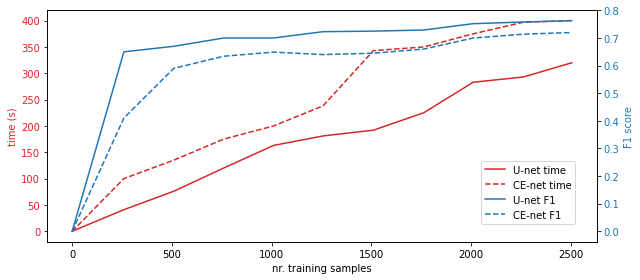

Figure 2. In this figure the effect of increasing the trainingsamples on trainingtimes 
and F1-score is visualised for U-net. The percentage of trainingsamples is taken per tissue type 
with random selection within the tissue types and averaged over three runs. Noteworthy 
is that the amount of trainingsamples does not influence the trainingtime and F1-score much.



In [2]:
import matplotlib.pyplot as plt 

time_Unet = [0, 41, 76, 120, 163, 181, 192, 225, 283, 293, 320] 
F1_Unet = [0, 0.65, 0.67, 0.70, 0.70, 0.723, 0.725, 0.729, 0.752, 0.758, 0.763 ] 
time_CEnet = [0, 100, 135, 175, 200, 238, 343, 350, 375, 397, 400]
F1_CEnet = [0, 0.41, 0.59, 0.634, 0.649, 0.640, 0.645, 0.66, 0.70, 0.714, 0.72]

training_samples  = [2504,2262,2010,1762,1510,1257,1009,759,509,259, 0 ]
training_samples.sort(reverse=False)
perc_of_data = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10,0]
perc_of_data.sort(reverse=False)


print('\n')
print('\033[1m' +  "SUBQUESTION: 1. What is the threshold number that results in the optimal performances of the model?" + '\033[0m')
print('\033[1m' + '             1c. How do the performance metrics respond to a smaller number of training samples?\n')

fig, ax1 = plt.subplots(figsize=(9,4))
color = 'tab:red'
ax1.set_xlabel('nr. training samples')
ax1.set_ylabel('time (s)', color=color)
ax1.plot(training_samples, time_Unet, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(training_samples, time_CEnet, color=color, ls='--')

ax2 = ax1.twinx() 
color = 'tab:blue'
ax2.set_ylabel('F1 score', color=color) 
ax2.plot(training_samples, F1_Unet, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(training_samples, F1_CEnet, color=color, ls='--')


fig.tight_layout() 
fig.legend(['U-net time', 'CE-net time','U-net F1', 'CE-net F1'], loc = (0.75, 0.2), ncol=1)

plt.show()
fig.savefig('trainingsamples.jpg')

print("Figure 2. In this figure the effect of increasing the trainingsamples on trainingtimes \nand F1-score is visualised for U-net. The percentage of trainingsamples is taken per tissue type \nwith random selection within the tissue types and averaged over three runs. Noteworthy \nis that the amount of trainingsamples does not influence the trainingtime and F1-score much.\n")

### Confidence interval for performance metrics

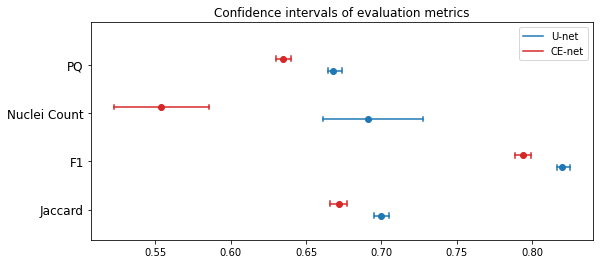

In [3]:
from matplotlib import pyplot, transforms

Unet = {'Jacc': [0.700, 0.695, 0.705], 'F1': [0.82, 0.81672, 0.82528], 'NuclCount': [0.691, 0.66126, 0.7274], 'PQ': [0.668, 0.66437, 0.67363]}
CEnet = {'Jacc': [0.672, 0.666, 0.6774], 'F1': [0.794, 0.7886, 0.7994], 'NuclCount': [0.554, 0.52236, 0.58564], 'PQ': [0.635, 0.62998, 0.64002]}


plt.figure(figsize=(9,4))
plt.ylim([0,9])
#plt.xlim([0.54, 0.83])

plt.plot(Unet['Jacc'][0], 1,  'o', c='tab:blue')
plt.plot((Unet['Jacc'][1],Unet['Jacc'][2]), (1,1),  'tab:blue')
plt.plot( (Unet['Jacc'][2], Unet['Jacc'][2]), (0.9,1.1), 'tab:blue')
plt.plot( (Unet['Jacc'][1], Unet['Jacc'][1]), (0.9,1.1), 'tab:blue')
plt.plot(CEnet['Jacc'][0], 1.5,  'o', c='tab:red')
plt.plot( (CEnet['Jacc'][1], CEnet['Jacc'][2]), (1.5,1.5), 'tab:red')
plt.plot( (CEnet['Jacc'][2], CEnet['Jacc'][2]), (1.4,1.6), 'tab:red')
plt.plot((CEnet['Jacc'][1], CEnet['Jacc'][1]),(1.4,1.6),  'tab:red')

plt.plot(Unet['F1'][0], 3,  'o', c='tab:blue')
plt.plot((Unet['F1'][1], Unet['F1'][2]),(3,3),  'tab:blue')
plt.plot((Unet['F1'][2], Unet['F1'][2]),(2.9,3.1),  'tab:blue')
plt.plot((Unet['F1'][1], Unet['F1'][1]),(2.9,3.1),  'tab:blue')
plt.plot(CEnet['F1'][0], 3.5,  'o', c='tab:red')
plt.plot((CEnet['F1'][1], CEnet['F1'][2]), (3.5,3.5),  c= 'tab:red')
plt.plot((CEnet['F1'][2], CEnet['F1'][2]), (3.4,3.6),  'tab:red')
plt.plot((CEnet['F1'][1], CEnet['F1'][1]), (3.4,3.6),  'tab:red')

plt.plot(Unet['NuclCount'][0], 5,  'o', c='tab:blue')
plt.plot( (Unet['NuclCount'][1], Unet['NuclCount'][2]), (5,5), 'tab:blue')
plt.plot((Unet['NuclCount'][2], Unet['NuclCount'][2]), (4.9,5.1),  'tab:blue')
plt.plot((Unet['NuclCount'][1], Unet['NuclCount'][1]), (4.9,5.1),  'tab:blue')
plt.plot(CEnet['NuclCount'][0], 5.5,  'o', c='tab:red')
plt.plot((CEnet['NuclCount'][1], CEnet['NuclCount'][2]), (5.5,5.5),  c= 'tab:red')
plt.plot((CEnet['NuclCount'][2], CEnet['NuclCount'][2]),(5.4,5.6),  'tab:red')
plt.plot((CEnet['NuclCount'][1], CEnet['NuclCount'][1]), (5.4,5.6),  'tab:red')

plt.plot(Unet['PQ'][0], 7,  'o', c='tab:blue')
plt.plot((Unet['PQ'][1], Unet['PQ'][2]), (7,7),  'tab:blue')
plt.plot((Unet['PQ'][2], Unet['PQ'][2]), (6.9,7.1),  'tab:blue', label= 'U-net')
plt.plot((Unet['PQ'][1], Unet['PQ'][1]), (6.9,7.1),  'tab:blue')
plt.plot(CEnet['PQ'][0], 7.5,  'o', c='tab:red')
plt.plot((CEnet['PQ'][1], CEnet['PQ'][2]), (7.5,7.5),  c= 'tab:red', label='CE-net')
plt.plot((CEnet['PQ'][2], CEnet['PQ'][2]), (7.4,7.6),  'tab:red')
plt.plot((CEnet['PQ'][1], CEnet['PQ'][1]), (7.4,7.6),  'tab:red')

plt.legend()
plt.yticks([1.25, 3.25, 5.25, 7.25], ['Jaccard', 'F1', 'Nuclei Count', 'PQ'], fontsize=12)
plt.title('Confidence intervals of evaluation metrics')

plt.savefig('confidence_intervals.jpg')




### Robustness of predictions for F1, Cell-count, PQ

0.8199650318262537
0.8132225543009314
0.7929896943937511
0.7834801916128878


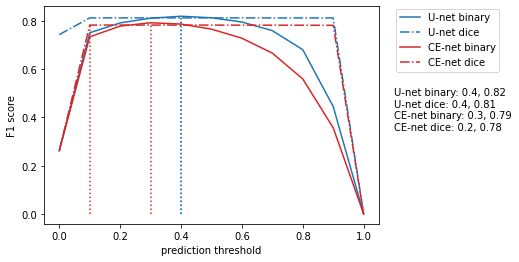

In [5]:
import matplotlib.pyplot as plt

threshold = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
f1_unet_dice = [0.7437099321816678, 0.8132225543009314, 0.8131719389258086, 0.8131491216644202,  0.8131175152549952, 0.8130715738147224, 0.8130339335084839, 0.8130121788455223,
 0.8129667505478853, 0.8128785457387173,  0.0]
f1_unet_bin = [0.26242096671896464,  0.7513819615372291, 0.7923879460579213,  0.811890413546121,  0.8199650318262537,  0.813657205208415, 0.7960653248930173,0.7601980443438746,  0.6812068391361267,  0.44535379817997844, 0.0]

jacc_unet = [0.158689256,0.592788712,0.653442009,0.690,0.697,0.692,0.667,0.617432885,0.526550623,0.350591604,0.199751489]


f1_cenet_binary = [0.26242096671896464, 0.734558329928564, 0.7791228469579579,  0.7929896943937511,  0.7874640732776819,  0.7664504740676625,  0.72881039352673,  0.6669177187537312,  0.5598193413084902,  0.35717434309444246,  0.0]
f1_cenet_dice = [0.26242096671896464, 0.7834801916128878,  0.7834555431625481,  0.7833456006562443,  0.7832563357775393,  0.7831643789518168,  0.7830564647509677,  0.782917467427458,  0.7827497591455495, 0.7823844686363088,  0.0]              

plt.plot(threshold, f1_unet_bin, color='tab:blue', label='U-net binary')
ymax = max(f1_unet_bin)
xpos = f1_unet_bin.index(ymax)
xmax = threshold[xpos]
print(ymax)
plt.plot([0.4, 0.4],[min(f1_unet_bin),0.812], ls=':', color='tab:blue')

plt.plot(threshold, f1_unet_dice, color='tab:blue', ls='-.', label='U-net dice')
ymax = max(f1_unet_dice)
xpos = f1_unet_dice.index(ymax)
xmax = threshold[xpos]
print(ymax)
plt.plot([0.4, 0.4],[min(f1_unet_dice),0.812], ls=':', color='tab:blue')



plt.plot(threshold, f1_cenet_binary, color='tab:red', label='CE-net binary')
ymax = max(f1_cenet_binary)
xpos = f1_cenet_binary.index(ymax)
xmax = threshold[xpos]
print(ymax)
plt.plot([xmax, xmax],[min(f1_cenet_binary),ymax], ls=':', color='tab:red')
plt.xlabel('prediction threshold')
plt.ylabel('F1 score')

plt.plot(threshold, f1_cenet_dice, color='tab:red', ls='-.', label='CE-net dice')
ymax = max(f1_cenet_dice)
xpos = f1_cenet_dice.index(ymax)
xmax = threshold[xpos]
print(ymax)
plt.plot([xmax, xmax],[min(f1_cenet_dice),max(f1_cenet_dice)], ls=':', color='tab:red')
plt.xlabel('prediction threshold')
plt.ylabel('F1 score')

plt.legend(loc=(1.05,0.7))
plt.text(x=1.1, y=0.3, s='U-net binary: 0.4, 0.82\nU-net dice: 0.4, 0.81\nCE-net binary: 0.3, 0.79\nCE-net dice: 0.2, 0.78\n')
plt.savefig('prediction threshold')





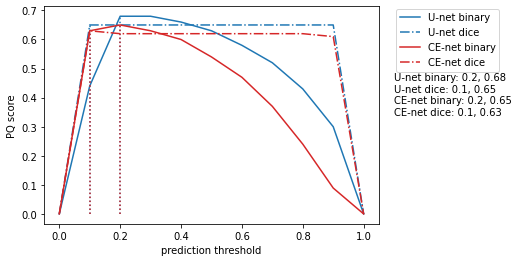

In [6]:
import matplotlib.pyplot as plt

threshold = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
PQ_unet_dice = [0.0, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.0]
PQ_unet_bin = [0.0, 0.44, 0.68, 0.68,  0.66, 0.63, 0.58, 0.52, 0.43, 0.30, 0.0]

PQ_cenet_binary = [0.0, 0.63, 0.65, 0.63, 0.60, 0.54, 0.47, 0.37, 0.24, 0.089, 0.0]
PQ_cenet_dice = [0.0, 0.63, 0.62, 0.62, 0.62, 0.62, 0.62, 0.62, 0.62, 0.61, 0.0]

plt.plot(threshold, PQ_unet_bin, color='tab:blue', label='U-net binary')
Unet_ymax_bin = max(PQ_unet_bin)
Unet_xpos_bin = PQ_unet_bin.index(Unet_ymax_bin)
Unet_xmax_bin = threshold[Unet_xpos_bin]
plt.plot([Unet_xmax_bin, Unet_xmax_bin],[min(PQ_unet_bin),Unet_ymax_bin], ls=':', color='tab:blue')

plt.plot(threshold, PQ_unet_dice, color='tab:blue', ls='-.', label='U-net dice')
Unet_ymax_dice = max(PQ_unet_dice)
Unet_xpos_dice = PQ_unet_dice.index(Unet_ymax_dice)
Unet_xmax_dice = threshold[Unet_xpos_dice]
plt.plot([Unet_xmax_dice, Unet_xmax_dice],[min(PQ_unet_dice),Unet_ymax_dice], ls=':', color='tab:blue')



plt.plot(threshold, PQ_cenet_binary, color='tab:red', label='CE-net binary')
CEnet_ymax_bin = max(PQ_cenet_binary)
CEnet_xpos_bin = PQ_cenet_binary.index(CEnet_ymax_bin)
CEnet_xmax_bin = threshold[CEnet_xpos_bin]
plt.plot([CEnet_xmax_bin, CEnet_xmax_bin],[min(PQ_cenet_binary),CEnet_ymax_bin], ls=':', color='tab:red')


plt.plot(threshold, PQ_cenet_dice, color='tab:red', ls='-.', label='CE-net dice')
CEnet_ymax_dice = max(PQ_cenet_dice)
CEnet_xpos_dice = PQ_cenet_dice.index(CEnet_ymax_dice)
CEnet_xmax_dice = threshold[CEnet_xpos_dice]
plt.plot([CEnet_xmax_dice,CEnet_xmax_dice],[min(PQ_cenet_dice),max(PQ_cenet_dice)], ls=':', color='tab:red')
plt.xlabel('prediction threshold')
plt.ylabel('PQ score')

plt.legend(loc=(1.05,0.7))
plt.text(x=1.1, y=0.3, s=f'U-net binary: {Unet_xmax_bin}, {Unet_ymax_bin}\nU-net dice: {Unet_xmax_dice}, {Unet_ymax_dice}\nCE-net binary: {CEnet_xmax_bin}, {CEnet_ymax_bin}\nCE-net dice: {CEnet_xmax_dice}, {CEnet_ymax_dice}\n')
plt.savefig('prediction threshold')





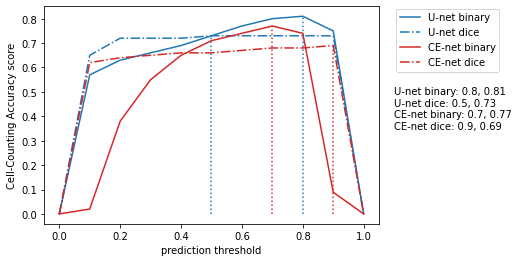

In [7]:
import matplotlib.pyplot as plt

threshold = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
PQ_unet_bin = [0.0, 0.57, 0.63, 0.66, 0.69, 0.73, 0.77, 0.80, 0.81, 0.75, 0.0]
PQ_unet_dice = [0.0, 0.65, 0.72, 0.72, 0.72, 0.73, 0.73, 0.73, 0.73, 0.73, 0.0]

PQ_cenet_binary = [0, 0.02, 0.38, 0.55, 0.65, 0.71, 0.74, 0.77, 0.74, 0.089, 0.0]
PQ_cenet_dice = [0, 0.62, 0.64, 0.65, 0.66, 0.66, 0.67, 0.68, 0.68, 0.69, 0.0]

plt.plot(threshold, PQ_unet_bin, color='tab:blue', label='U-net binary')
Unet_ymax_bin = max(PQ_unet_bin)
Unet_xpos_bin = PQ_unet_bin.index(Unet_ymax_bin)
Unet_xmax_bin = threshold[Unet_xpos_bin]
plt.plot([Unet_xmax_bin, Unet_xmax_bin],[min(PQ_unet_bin),Unet_ymax_bin], ls=':', color='tab:blue')

plt.plot(threshold, PQ_unet_dice, color='tab:blue', ls='-.', label='U-net dice')
Unet_ymax_dice = max(PQ_unet_dice)
Unet_xpos_dice = PQ_unet_dice.index(Unet_ymax_dice)
Unet_xmax_dice = threshold[Unet_xpos_dice]
plt.plot([Unet_xmax_dice, Unet_xmax_dice],[min(PQ_unet_dice),Unet_ymax_dice], ls=':', color='tab:blue')



plt.plot(threshold, PQ_cenet_binary, color='tab:red', label='CE-net binary')
CEnet_ymax_bin = max(PQ_cenet_binary)
CEnet_xpos_bin = PQ_cenet_binary.index(CEnet_ymax_bin)
CEnet_xmax_bin = threshold[CEnet_xpos_bin]
plt.plot([CEnet_xmax_bin, CEnet_xmax_bin],[min(PQ_cenet_binary),CEnet_ymax_bin], ls=':', color='tab:red')


plt.plot(threshold, PQ_cenet_dice, color='tab:red', ls='-.', label='CE-net dice')
CEnet_ymax_dice = max(PQ_cenet_dice)
CEnet_xpos_dice = PQ_cenet_dice.index(CEnet_ymax_dice)
CEnet_xmax_dice = threshold[CEnet_xpos_dice]
plt.plot([CEnet_xmax_dice,CEnet_xmax_dice],[min(PQ_cenet_dice),max(PQ_cenet_dice)], ls=':', color='tab:red')
plt.xlabel('prediction threshold')
plt.ylabel('Cell-Counting Accuracy score')

plt.legend(loc=(1.05,0.7))
plt.text(x=1.1, y=0.3, s=f'U-net binary: {Unet_xmax_bin}, {Unet_ymax_bin}\nU-net dice: {Unet_xmax_dice}, {Unet_ymax_dice}\nCE-net binary: {CEnet_xmax_bin}, {CEnet_ymax_bin}\nCE-net dice: {CEnet_xmax_dice}, {CEnet_ymax_dice}\n')
plt.savefig('prediction threshold')



